In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from os.path import join
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras.backend as K

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.dic import dic

%matplotlib inline 

DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

Using TensorFlow backend.


In [2]:
config = dic.DicConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        40
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [12]:
dataset_name = 'dic'

MODEL_DIR = "G:/DataForDL/logs/mrcnn/choosed/{}".format(dataset_name)
DIC_WEIGHTS_PATH = join(MODEL_DIR, 'mask_rcnn_{}_0040.h5'.format(dataset_name))  # TODO: update this path

DIC_DIR = os.path.join(ROOT_DIR, "datasets/dic_sample")

In [14]:
dataset = dic.DicDataset()
dataset.load_dic(DIC_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'dic']


In [20]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(DIC_WEIGHTS_PATH, by_name=True)

In [16]:
def miou(y_true, y_pred):
    label = tf.reshape(y_true, y_true.shape)
    pred = tf.reshape(y_pred, y_pred.shape)

    iou_op = tf.metrics.mean_iou(label, pred ,2)
    with tf.Session() as sess:
    # sess.run(tf.global_variables_initializer()) 
        K.get_session().run(tf.local_variables_initializer())

        sess.run(iou_op)
        mean_iou, conf_mat = sess.run(iou_op)
        return mean_iou


def clip2one(masks):
    mask = masks.sum(axis=-1)
    return np.where(mask==0, 0, 1)

In [ ]:
# Load and display random samples
Miou = []
for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    # print(image.shape, mask.shape)
    pred = model.detect([image], verbose=1)[0]['masks']
    t, p = clip2one(mask), clip2one(pred)
    # print(t.max(), t.shape, p.max(), p.shape)
    Miou.append(miou(t, p))
print(np.mean(Miou))

Processing 1 images
image                    shape: (512, 512, 3)         min:   37.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -86.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


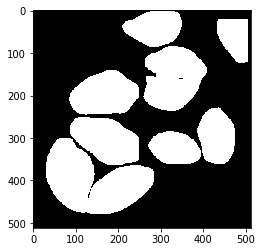

In [12]:
plt.imshow(p, cmap='gray')